In [1]:
import re
import csv
import sys
import random
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


# import tables for Java, python and R
rUsers= pd.read_csv("r_users.csv")

# import tables for Java, python and R
rUsers= pd.read_csv("r_users.csv")
pythonUsers= pd.read_csv("python_users.csv")
javaUsers=pd.read_csv("java_users.csv") 

javaQuestions = pd.read_csv("java_questions.csv",error_bad_lines=False)
pythonQuestions= pd.read_csv("python_questions.csv",error_bad_lines=False)
rQuestions= pd.read_csv("r_questions.csv")

javaAnswers = pd.read_csv("java_answers.csv",error_bad_lines=False)
pythonAnswers = pd.read_csv("python_answers.csv",error_bad_lines=False) 
rAnswers= pd.read_csv("r_answers.csv")



b'Skipping line 325621: expected 10 fields, saw 23\n'
b'Skipping line 336660: expected 10 fields, saw 74\nSkipping line 366638: expected 10 fields, saw 19\n'
b'Skipping line 455722: expected 10 fields, saw 11\n'
b'Skipping line 804123: expected 10 fields, saw 19\n'
b'Skipping line 865079: expected 10 fields, saw 12\nSkipping line 866131: expected 10 fields, saw 15\n'
C:\Users\baren\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
b'Skipping line 1122646: expected 7 fields, saw 12\n'


In [2]:
def upMetricCreation(table):
    answersTable =table.copy()
    
    answersTable[' AbsSum']= answersTable[' Score'].abs()

    # the absolute total score by question
    questiondf = answersTable.groupby([' ParentId'])[' AbsSum'].sum()
    
    questiondf = pd.DataFrame(questiondf)
    questiondf= questiondf.reset_index()
                
    #merge the table of answers and question
    answersTable= answersTable.merge(questiondf,left_on=' ParentId',suffixes=('', 'Global'), right_on=' ParentId', how='left')
    answersTable   
    
    # Score relative to the question, multiplied by the signal of the "individual" score
    answersTable[' RelativeScore'] =  answersTable[' AbsSum'] / answersTable[' AbsSumGlobal']  
    
    answersTable.loc[answersTable[' Score'] < 0,' RelativeScore'] = - answersTable[' RelativeScore'] 
    answersTable.loc[answersTable[' Score'] == 0,' RelativeScore'] =0
    
    # The cum. number of questions answers by user 
    answersTable['CumSumQuestions'] = answersTable.groupby(' OwnerUserId').cumcount() + 1
    
    answersTable=answersTable.sort_values([' OwnerUserId',' CreationDate']) #order by user
    
    answersTable['CumScore'] = answersTable.groupby(' OwnerUserId')[' RelativeScore'].cumsum()
    
    
    answersTable=answersTable.sort_values([' OwnerUserId',' CreationDate']) #order by user
    
    

    answersTable['UpMetric'] = answersTable['CumScore']/answersTable['CumSumQuestions'] 
    return(answersTable)

In [3]:
# UpMetric creation for every language
rAnswers = upMetricCreation(rAnswers)
pythonAnswers = upMetricCreation(pythonAnswers)
javaAnswers = upMetricCreation(javaAnswers)


In [4]:
def formatCreationDateColumn(table_provided):
    table = table_provided.copy()
    #Correcting format of dates in the table
    table[" CreationDate"]=pd.to_datetime(table[" CreationDate"],errors="coerce")
    
    #remove lines which could not be formatted to correct date format
    table=table.loc[~table[" CreationDate"].isnull()]
    
    return(table)

In [5]:
# format data column for all the tables
rAnswers = formatCreationDateColumn(rAnswers)
javaAnswers = formatCreationDateColumn(javaAnswers)
pythonAnswers = formatCreationDateColumn(pythonAnswers)

rQuestions = formatCreationDateColumn(rQuestions)
javaQuestions = formatCreationDateColumn(javaQuestions)
pythonQuestions = formatCreationDateColumn(pythonQuestions)

In [6]:
def gettingTableUserFirstActivity(answersTable_provided,questionsTable_provided):
    answersTable = answersTable_provided.copy()
    questionsTable = questionsTable_provided.copy()
   
    #identify the first activity of users
    answersTable["FirstActivity"]=~answersTable[" OwnerUserId"].duplicated()
    questionsTable["FirstActivity"]=~questionsTable[" OwnerUserId"].duplicated()
    
    #obtaining first answer and first question of a user
    firstAnswers=answersTable.loc[answersTable["FirstActivity"]==True][[" OwnerUserId"," CreationDate"]]

    firstQuestions = questionsTable.loc[questionsTable["FirstActivity"]==True][[" OwnerUserId"," CreationDate"]]
  
    #and merge them into one table
    firstActTable=firstQuestions.merge(firstAnswers, left_on=" OwnerUserId", right_on=" OwnerUserId", how='outer')
    firstActTable.columns = [" OwnerUserId","FirstQuestion","FirstAnswer"]
    
    #obtain first activity (either answer or question)
    firstActTable["FirstActivity"]=firstActTable[["FirstQuestion","FirstAnswer"]].min(axis=1)
    
    
    return(firstActTable)

In [7]:
# get first activity per user in all the languages
rFirstActTable = gettingTableUserFirstActivity(rAnswers,rQuestions)
javaFirstActTable = gettingTableUserFirstActivity(javaAnswers,javaQuestions)
pythonFirstActTable = gettingTableUserFirstActivity(pythonAnswers,pythonQuestions)

In [8]:
def obtainSummaryUpMetric(answersTable,questionsTable,firstActTable):
    
    #Adding first activity table to answerstable 
    summaryTableAnswer = answersTable[["Id"," OwnerUserId"," CreationDate"," ParentId","UpMetric"]]
    summaryTableAnswer=summaryTableAnswer.merge(firstActTable,left_on = " OwnerUserId",right_on=" OwnerUserId")
    
    #Use first activity to obtain normalized time
    summaryTableAnswer["Present"]= max(summaryTableAnswer[" CreationDate"])
    
    #timestamp of answer compared to first activity of that user
    summaryTableAnswer["DifferenceNumerator"]=(summaryTableAnswer[" CreationDate"]-summaryTableAnswer["FirstActivity"])
    summaryTableAnswer["DifferenceDenominator"]=(summaryTableAnswer["Present"]-summaryTableAnswer["FirstActivity"])
    
    summaryTableAnswer.DifferenceNumerator=summaryTableAnswer.DifferenceNumerator.dt.total_seconds() /(24*3600) # to obtain days with decimals
    summaryTableAnswer.DifferenceDenominator=summaryTableAnswer.DifferenceDenominator.dt.total_seconds()/(24*3600)
    summaryTableAnswer["NormTime"]=summaryTableAnswer["DifferenceNumerator"]/summaryTableAnswer["DifferenceDenominator"]
    
    return(summaryTableAnswer)



In [9]:
# obtainSummaryUpMetric per language
rSummaryUpMetricAnswer = obtainSummaryUpMetric(rAnswers,rQuestions,rFirstActTable)
rSummaryUpMetricAnswer = rSummaryUpMetricAnswer.sort_values([' CreationDate'])
javaSummaryUpMetricAnswer = obtainSummaryUpMetric(javaAnswers,javaQuestions,javaFirstActTable)
javaSummaryUpMetricAnswer = javaSummaryUpMetricAnswer.sort_values([' CreationDate'])
pythonSummaryUpMetricAnswer = obtainSummaryUpMetric(pythonAnswers,pythonQuestions,pythonFirstActTable)
pythonSummaryUpMetricAnswer = pythonSummaryUpMetricAnswer.sort_values([' CreationDate'])

In [10]:
def removeUsersWithFewAnswers(answersTable,summaryTableAnswer):
    nrQuestionsperUser = answersTable[" OwnerUserId"].value_counts()
    lessthan5users=nrQuestionsperUser[nrQuestionsperUser<5].index
    nrUsersBefore=len(list(set(summaryTableAnswer[" OwnerUserId"].tolist())))
    filteredTable=summaryTableAnswer.loc[~summaryTableAnswer[" OwnerUserId"].isin(lessthan5users)]
    nrUsersAfter=len(list(set(filteredTable[" OwnerUserId"].tolist())))
    print(1-nrUsersAfter/nrUsersBefore,"% of the users were removed.")
    return(filteredTable)

In [11]:
# take away users with few answers
rSummaryUpMetricAnswerFew = removeUsersWithFewAnswers(rAnswers,rSummaryUpMetricAnswer)
javaSummaryUpMetricAnswerFew = removeUsersWithFewAnswers(javaAnswers,javaSummaryUpMetricAnswer)
pythonSummaryUpMetricAnswerFew = removeUsersWithFewAnswers(pythonAnswers, pythonSummaryUpMetricAnswer)

0.8437442133201654 % of the users were removed.
0.8169454999149323 % of the users were removed.
0.8319620773003543 % of the users were removed.


In [12]:
def addZeroTimepoint(summaryTableAnswer_provided):
    summaryTableAnswer=summaryTableAnswer_provided.copy()
    #Add 0 to time 0
    usersWhoHaveZero=list(set(summaryTableAnswer[" OwnerUserId"][summaryTableAnswer["NormTime"]==0].tolist()))
    usersArtificialZero = list(set(summaryTableAnswer[" OwnerUserId"][~summaryTableAnswer[" OwnerUserId"].isin(usersWhoHaveZero)].tolist()))
    tempdfArtificialZero = pd.DataFrame(0, index=np.arange(len(usersArtificialZero)), columns=list(summaryTableAnswer.columns.values))
    tempdfArtificialZero[" OwnerUserId"]=usersArtificialZero
    tempdfArtificialZero[" OwnerUserId"]=tempdfArtificialZero[" OwnerUserId"].astype(np.int64) # make type correct
    summaryTableAnswer = summaryTableAnswer.append(tempdfArtificialZero, ignore_index=True)

    #reorder again
    summaryTableAnswer=summaryTableAnswer.sort_values([' OwnerUserId','NormTime']) #order by user
    return(summaryTableAnswer)



rSummaryUpMetricAnswerFew = addZeroTimepoint(rSummaryUpMetricAnswerFew)
javaSummaryUpMetricAnswerFew = addZeroTimepoint(javaSummaryUpMetricAnswerFew)
pythonSummaryUpMetricAnswerFew = addZeroTimepoint(pythonSummaryUpMetricAnswerFew)

In [13]:
def plotEvolutionRandomUsers(summaryTableAnswer,language):
    r_users=summaryTableAnswer.loc[np.random.choice(summaryTableAnswer.index, 6)][" OwnerUserId"].tolist()
    plt.figure(figsize=(12,8))

    for i in range(0,6):
        user=r_users[i]
        plt.subplot(3,2,i+1)
        plt.xlabel("Days since first activity in "+language)
        plt.ylabel("Ratio of Up Votes within a Question")
        plt.plot(summaryTableAnswer.loc[summaryTableAnswer[" OwnerUserId"]==user]["DifferenceNumerator"].tolist(),summaryTableAnswer.loc[summaryTableAnswer[" OwnerUserId"]==user]["UpMetric"].tolist())
    
    plt.tight_layout()
    plt.show()

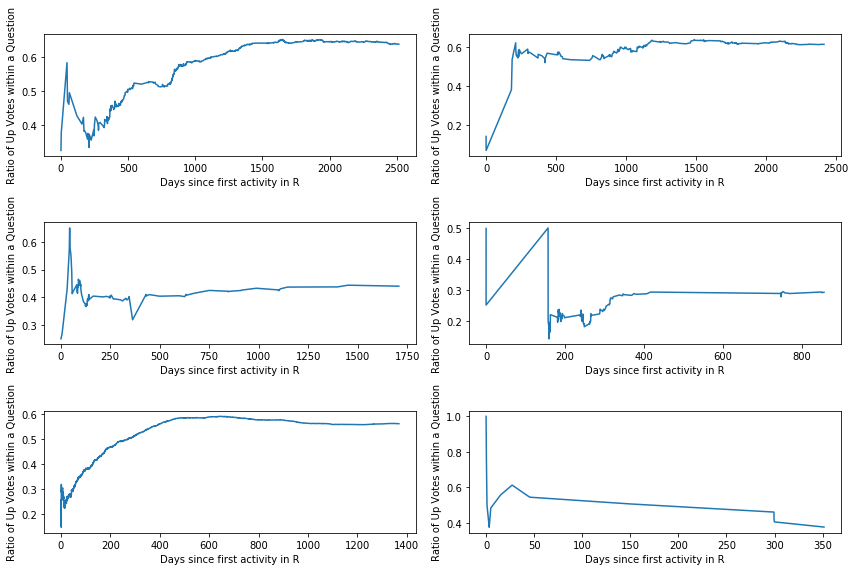

In [14]:
######## plots ###
plotEvolutionRandomUsers(rSummaryUpMetricAnswer,"R")
#plotEvolutionRandomUsers(javaSummaryUpMetricAnswer,"JAVA")
#plotEvolutionRandomUsers(pythonSummaryUpMetricAnswer,"Python")

In [15]:
def aggregateIndividualLearningCurves(summaryTableProbAccAnswer,thresExpertise,threshUsers):
    #possible timepoints from 0 to the maximum span.
    x_all = np.linspace(0, max(summaryTableProbAccAnswer["DifferenceDenominator"]),num=5000, endpoint=True)
    #variable initialization
    sumProbs = np.zeros(len(x_all))
    nrUsers = np.zeros(len(x_all))
    users = list(set(summaryTableProbAccAnswer[" OwnerUserId"].tolist()))
    #total = np.empty((len(x_all),len(users),))
    #total.fill(np.nan)
    consUsers=0 #considered users
    i=0
    #for each user:
    #linear interpolation - already checked that curve shape is similar to the ones obtained individually
    for user in users:
        xs_user=summaryTableProbAccAnswer["DifferenceNumerator"][summaryTableProbAccAnswer[" OwnerUserId"]==user].tolist()
        probs_user= summaryTableProbAccAnswer["UpMetric"][summaryTableProbAccAnswer[" OwnerUserId"]==user].tolist()
        
        #interpolation function for this user
        f1 = interp1d(xs_user,probs_user ,'linear')
        
        # only interpolated values are considered, meaning no extrapolated values
        subset_x_all=x_all[x_all<max(xs_user)]
        f1_int = f1(subset_x_all)
    
        
        # only users that are considered to achieve expertise will be taken into consideration for computing the learning curve
        if (min(probs_user[-5:])>thresExpertise):
            consUsers=consUsers+1
            #total[0:len(subset_x_all),i]=f1_int
            #update probability sums at each time point with the interpolated probabilities for this user
            sumProbs[0:len(subset_x_all)]=sumProbs[0:len(subset_x_all)]+f1_int
            #update nr users 
            nrUsers[0:len(subset_x_all)] = nrUsers[0:len(subset_x_all)]+1
            #i=i+1

    
    #Remove timepoints which have less than a threshold number of users
    noUsersPos = np.where(nrUsers>threshUsers)
    sumProbs=sumProbs[noUsersPos]
    nrUsers=nrUsers[noUsersPos]
    x_all=x_all[noUsersPos]
    #total = total[noUsersPos,:]
    probs=sumProbs/nrUsers
    
    print((len(users)-consUsers)/len(users), " were not considered")
    print (consUsers, " were considered in total")
    
    return([x_all,probs])

def plotAvgCurve(x_all,probs,language):    
    plt.figure()
    plt.xlabel("Days since first activity in " + language)
    plt.ylabel("Probability of answer\ngetting accepted")
    plt.plot(x_all, probs)
    plt.show()
      

In [17]:
[Rx_all,Rprobs]=aggregateIndividualLearningCurves(rSummaryUpMetricAnswerFew,-1.1,100)
[Jx_all,Jprobs]=aggregateIndividualLearningCurves(javaSummaryUpMetricAnswerFew,-1.1,100)
[Px_all,Pprobs]=aggregateIndividualLearningCurves(pythonSummaryUpMetricAnswerFew,-1.1,100)

0.0  were not considered
5063  were considered in total
0.0  were not considered
64556  were considered in total
0.0  were not considered
35803  were considered in total


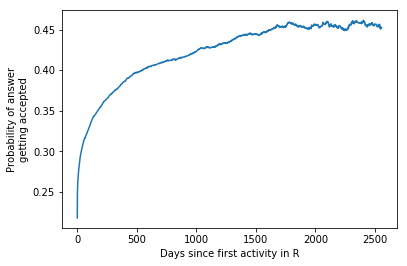

In [18]:
plotAvgCurve(Rx_all,Rprobs,"R")

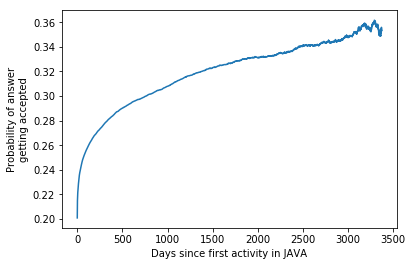

In [19]:
plotAvgCurve(Jx_all,Jprobs,"JAVA")

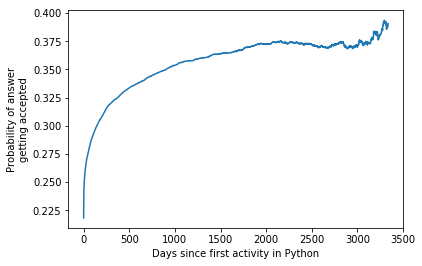

In [20]:
plotAvgCurve(Px_all,Pprobs,"Python")

# Modeling

In [21]:
import lmfit

In [22]:
#Models Explored
def negExpo(t,S0,M,lbda):
    return S0 + (M-S0)*(1-np.exp(-lbda*t))

def negExpoModif(t,S0,M,lbda,k):
    return S0 + (M-S0)*(1-np.exp(-lbda*t))+k*t

def powerLaw (t,b,a,c):
    return c+np.power(b*t,a)

def logarithmic(t,c,a):
    return c+a*np.log(t+1)

In [23]:
#Model Fitting
def modelsFitting(x_all,probs,meth,i_S0,i_M,i_lbd,i_k,i_b,i_a,i_c,i_la,i_lc):
    #negExpo
    modelNegExpo =lmfit.Model(negExpo,independent_vars=["t"])
    resultNegExpo = modelNegExpo.fit(np.array(probs),t=np.array(x_all),S0=i_S0,M=i_M,lbda=i_lbd,method=meth)

    #negExpo 
    modelNegExpoModif =lmfit.Model(negExpoModif,independent_vars=["t"])
    resultNegExpoModif = modelNegExpoModif.fit(np.array(probs),t=np.array(x_all),S0=i_S0,M=i_M,lbda=i_lbd,k=i_k,method=meth)

    #powerLaw
    modelPowerLaw=lmfit.Model(powerLaw,independent_vars=["t"])
    resultPowerLaw = modelPowerLaw.fit(np.array(probs),t=np.array(x_all),b=i_b,a=i_a,c=i_c,method=meth,nan_policy='omit')

    #logarithmic
    modelLog=lmfit.Model(logarithmic,independent_vars=["t"])
    resultLog = modelLog.fit(np.array(probs),t=np.array(x_all),a=i_la,c=i_lc,method=meth) 

    return([resultNegExpo,resultNegExpoModif,resultPowerLaw,resultLog])

In [31]:
#plotting model - Experiments
def plotExperiments(x_all,probs,language,i_S0,i_M,i_lbd,i_k,i_b,i_a,i_c,i_la,i_lc):
    plt.figure(figsize=(12,8))
    plt.subplot(2,2,1)
    plt.plot(x_all,probs)
    plt.plot(x_all,negExpo(t=x_all,S0=i_S0,M=i_M,lbda=i_lbd))
    plt.title("Negative Exponential - "+language)

    plt.subplot(2,2,2)
    plt.plot(x_all,probs)
    plt.plot(x_all,negExpoModif(t=x_all,S0=i_S0,M=i_M,lbda=i_lbd,k=i_k))
    plt.title("Negative Exponential Modified - "+language)

    plt.subplot(2,2,3)
    plt.plot(x_all,probs)
    plt.plot(x_all,powerLaw(t=x_all,b=i_b,a=i_a,c=i_c))
    plt.title("Power Law - "+language)

    plt.subplot(2,2,4)
    plt.plot(x_all,probs)
    plt.plot(x_all,logarithmic(t=x_all,a=i_la,c=i_lc))
    plt.title("Logarithmic - "+language)
    plt.show()

def plotModelResults (x_all,probs,language,i_S0,i_M,i_lbd,i_k,i_b,i_a,i_c,i_la,i_lc):
    #Compare model with data
    [resultNegExpo,resultNegExpoModif,resultPowerLaw,resultLog] = modelsFitting(x_all,probs,"leastsq",i_S0,i_M,i_lbd,i_k,i_b,i_a,i_c,i_la,i_lc)
    # Least Squares Optimization
    plt.figure(figsize=(12,8))
    plt.subplot(2,2,1)
    #plotting model - Negative Exponential
    plt.plot(x_all,probs)
    plt.plot(x_all,negExpo(t=x_all,**resultNegExpo.values))
    plt.title("Negative Exponential- "+language)

    plt.subplot(2,2,2)
    #plotting model - Negative Exponential Modified
    plt.plot(x_all,probs)
    plt.plot(x_all,negExpoModif(t=x_all,**resultNegExpoModif.values))
    plt.title("Negative Exponential Modified- "+language)

    plt.subplot(2,2,3)
    #plotting model - PowerLaw
    plt.plot(x_all,probs)
    plt.plot(x_all,powerLaw(t=x_all,**resultPowerLaw.values))
    plt.title("Power Law- "+language)

    plt.subplot(2,2,4)
    #plotting model - Logarithmic
    plt.plot(x_all,probs)
    plt.plot(x_all,logarithmic(t=x_all,**resultLog.values))
    plt.title("Logarithmic- "+language)
    plt.show
    
    #Print Goodness of fit
    #Assess Goodness of fit
    print(resultNegExpo.fit_report(min_correl=0.25))
    print(resultNegExpoModif.fit_report(min_correl=0.25))
    print(resultPowerLaw.fit_report(min_correl=0.25))
    print(resultLog.fit_report(min_correl=0.25))

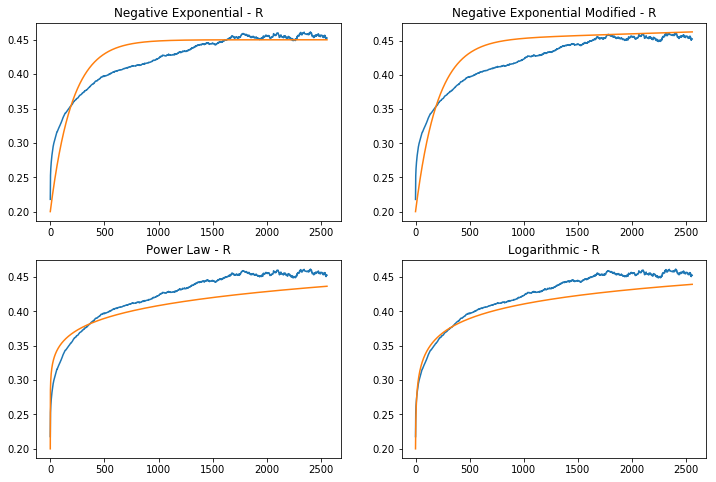

In [32]:
plotExperiments(Rx_all,Rprobs,"R",0.2,0.45,0.005,0.000005,0.000000009,.135,.2,.0305,.2)

[[Model]]
    Model(negExpo)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 27
    # data points      = 3693
    # variables        = 3
    chi-square         = 0.13362486
    reduced chi-square = 3.6213e-05
    Akaike info crit   = -37761.9911
    Bayesian info crit = -37743.3485
[[Variables]]
    S0:    0.30431166 +/- 4.4958e-04 (0.15%) (init = 0.2)
    M:     0.45777338 +/- 2.2632e-04 (0.05%) (init = 0.45)
    lbda:  0.00168961 +/- 1.0925e-05 (0.65%) (init = 0.005)
[[Correlations]] (unreported correlations are < 0.250)
    C(M, lbda)  = -0.807
    C(S0, lbda) = -0.705
    C(S0, M)    =  0.399

[[Model]]
    Model(negExpoModif)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 58
    # data points      = 3693
    # variables        = 4
    chi-square         = 0.09681250
    reduced chi-square = 2.6244e-05
    Akaike info crit   = -38950.0980
    Bayesian info crit = -38925.2412
[[Variables]]
    S0:    0.28959291 +/- 5.2928e-0

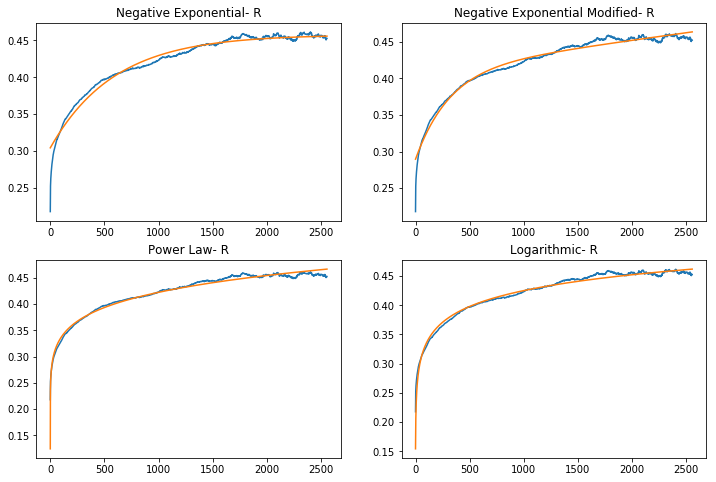

In [33]:
plotModelResults(Rx_all,Rprobs,"R",0.2,0.45,0.005,0.000005,0.000000009,.135,.2,.0305,.2)

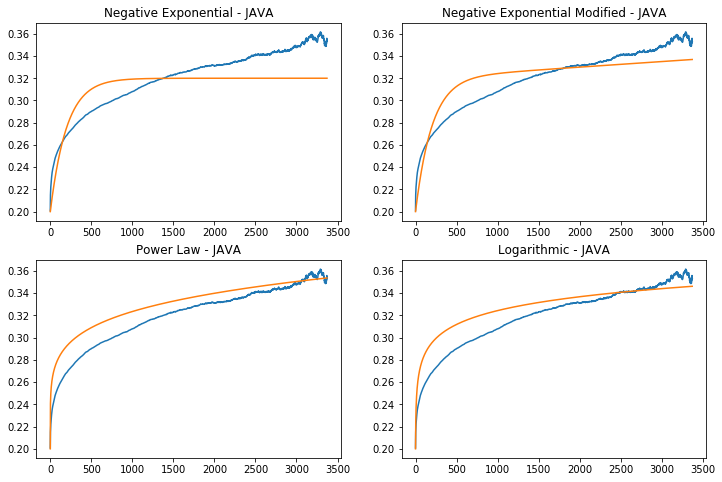

In [66]:
plotExperiments(Jx_all,Jprobs,"JAVA",0.2,0.32,0.005,0.000005,0.000000009,.18,.2,.018,.2)

[[Model]]
    Model(negExpo)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 36
    # data points      = 3600
    # variables        = 3
    chi-square         = 0.03659668
    reduced chi-square = 1.0174e-05
    Akaike info crit   = -41381.3529
    Bayesian info crit = -41362.7869
[[Variables]]
    S0:    0.24537943 +/- 2.1290e-04 (0.09%) (init = 0.2)
    M:     0.34177978 +/- 2.1530e-04 (0.06%) (init = 0.32)
    lbda:  0.00112940 +/- 7.8344e-06 (0.69%) (init = 0.05)
[[Correlations]] (unreported correlations are < 0.250)
    C(M, lbda)  = -0.915
    C(S0, lbda) = -0.715
    C(S0, M)    =  0.508

[[Model]]
    Model(negExpoModif)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 60
    # data points      = 3600
    # variables        = 4
    chi-square         = 0.01552643
    reduced chi-square = 4.3177e-06
    Akaike info crit   = -44466.0420
    Bayesian info crit = -44441.2873
[[Variables]]
    S0:    0.23426683 +/- 2.2167e-04

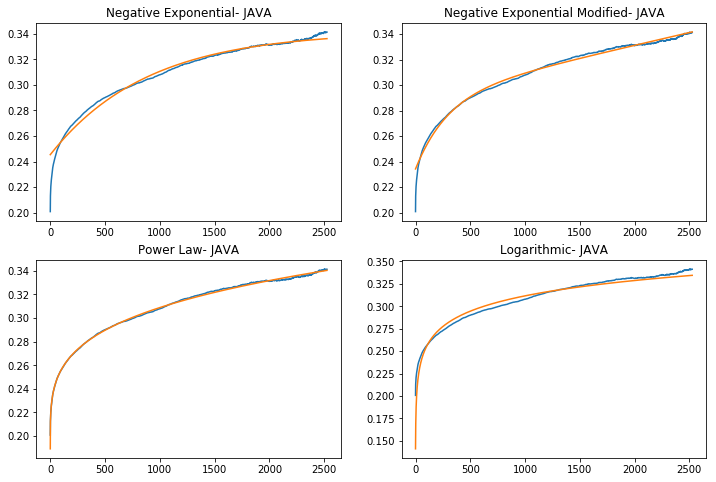

In [70]:
plotModelResults(Jx_all[0:3600],Jprobs[0:3600],"JAVA",0.2,0.32,0.05,0.000005,0.000000009,.18,.2,.018,.2)

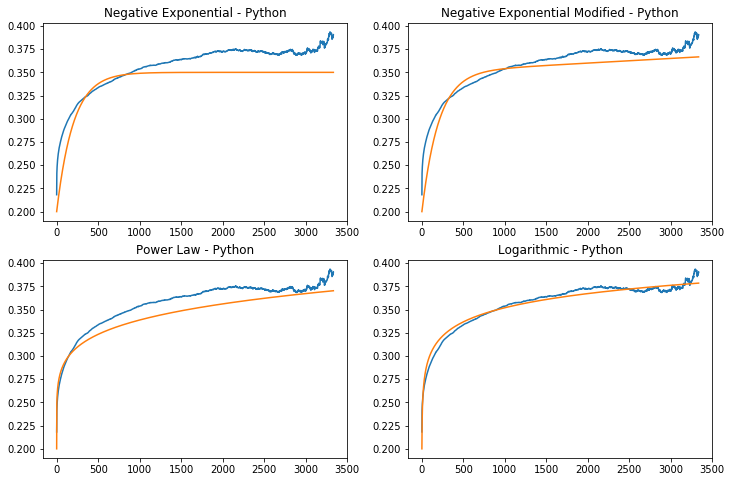

In [54]:
plotExperiments(Px_all,Pprobs,"Python",0.2,0.35,0.005,0.000005,0.000000009,.17,.2,.022,.2)

[[Model]]
    Model(negExpo)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 27
    # data points      = 3600
    # variables        = 3
    chi-square         = 0.04745743
    reduced chi-square = 1.3194e-05
    Akaike info crit   = -40445.8005
    Bayesian info crit = -40427.2345
[[Variables]]
    S0:    0.27359622 +/- 2.7696e-04 (0.10%) (init = 0.2)
    M:     0.37325997 +/- 1.3494e-04 (0.04%) (init = 0.35)
    lbda:  0.00174864 +/- 1.0569e-05 (0.60%) (init = 0.005)
[[Correlations]] (unreported correlations are < 0.250)
    C(M, lbda)  = -0.800
    C(S0, lbda) = -0.705
    C(S0, M)    =  0.392

[[Model]]
    Model(negExpoModif)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 48
    # data points      = 3600
    # variables        = 4
    chi-square         = 0.02383104
    reduced chi-square = 6.6271e-06
    Akaike info crit   = -42923.6403
    Bayesian info crit = -42898.8856
[[Variables]]
    S0:    0.26250535 +/- 2.7849e-0

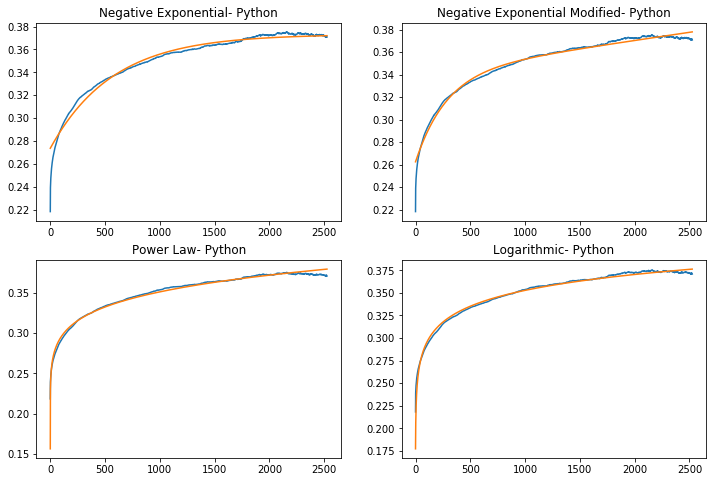

In [68]:
plotModelResults(Px_all[0:3600],Pprobs[0:3600],"Python",0.2,0.35,0.005,0.000005,0.000000009,.17,.2,.022,.2)